## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [11]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [2]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [26]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [27]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Data Visualization**

Found 2239 files belonging to 9 classes.


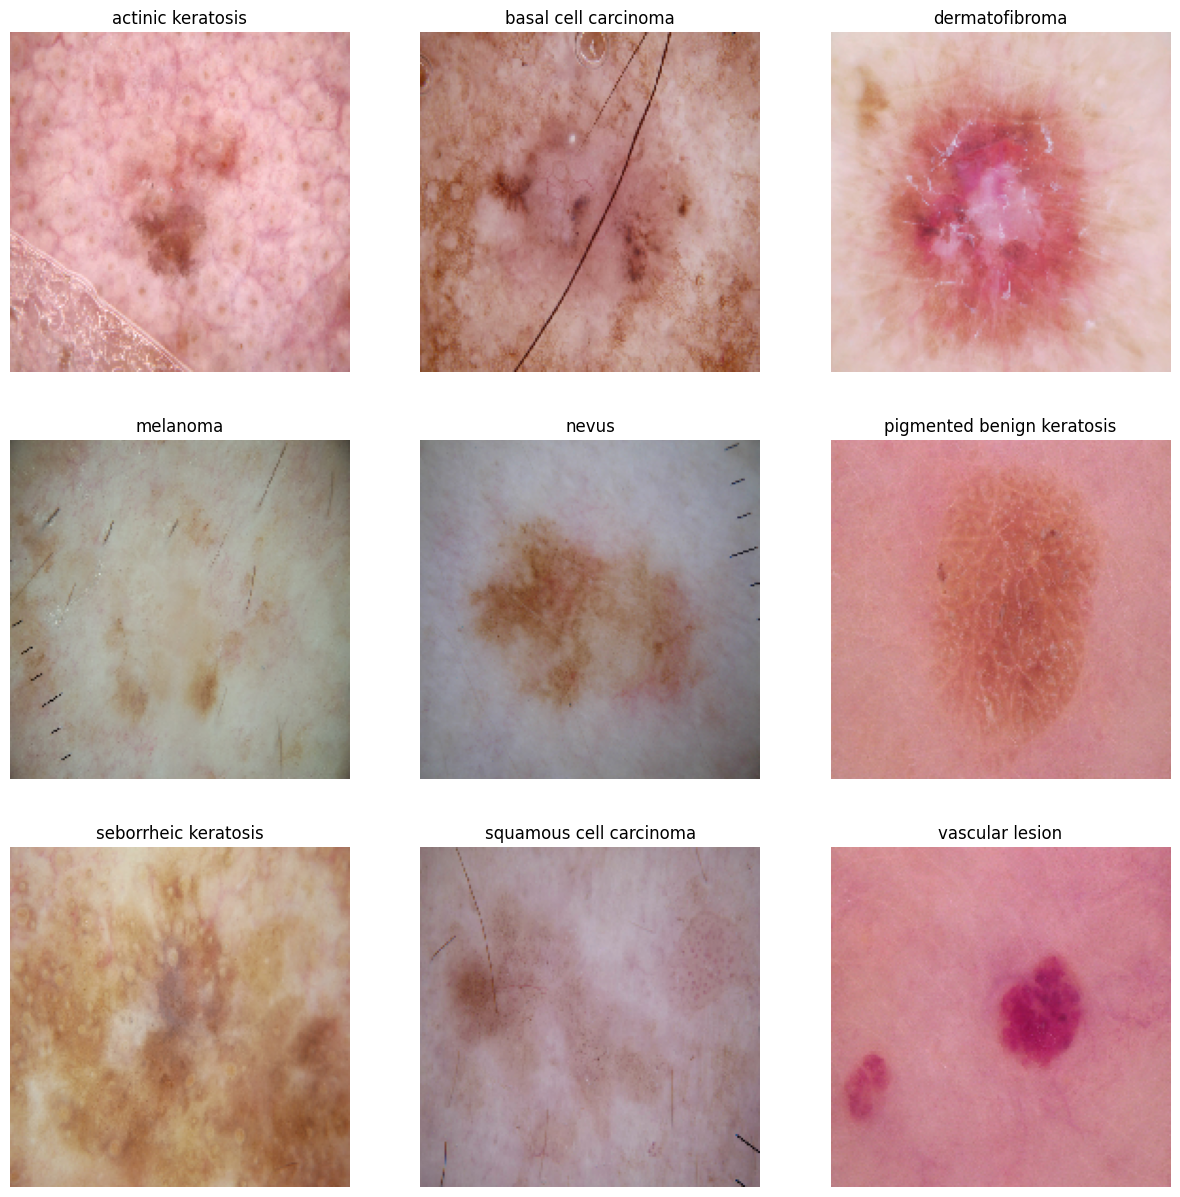

In [28]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [29]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,pigmented benign keratosis,462
1,vascular lesion,139
2,seborrheic keratosis,77
3,basal cell carcinoma,376
4,dermatofibroma,95
5,melanoma,438
6,nevus,357
7,squamous cell carcinoma,181
8,actinic keratosis,114


<Axes: xlabel='No. of Image', ylabel='Class'>

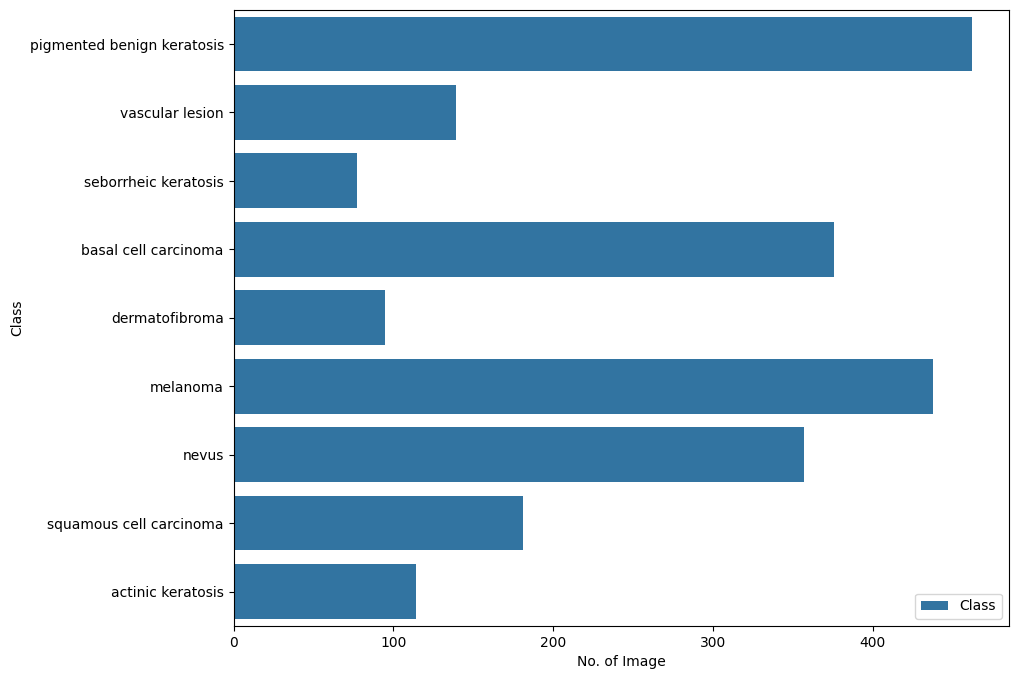

In [30]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
#install Augmentor
!pip install Augmentor

In [32]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E8DFEA11B40>: 100%|██████████| 500/500 [00:16<00:00, 30.14 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E8DAE5CE530>: 100%|██████████| 500/500 [00:14<00:00, 33.78 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8DFEB0E350>: 100%|██████████| 500/500 [00:14<00:00, 33.35 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E8D90972140>: 100%|██████████| 500/500 [01:29<00:00,  5.60 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E8DE0747550>: 100%|██████████| 500/500 [01:17<00:00,  6.46 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8DE01C79A0>: 100%|██████████| 500/500 [00:15<00:00, 32.24 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E8DE0246560>: 100%|██████████| 500/500 [00:33<00:00, 14.81 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8DEF7C48E0>: 100%|██████████| 500/500 [00:14<00:00, 35.32 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8D9D32B8E0>: 100%|██████████| 500/500 [00:14<00:00, 33.98 Samples/s]


In [33]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Model Building**

In [34]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [35]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [36]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
# CNN Model Architecture

# Sequential allows you to create models layer-by-layer
model = Sequential()

# Use Rescaling directly from keras.layers
model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))  # Rescaling Layer

# First Convolutional layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with 50% fraction of the input units to drop
model.add(layers.Dropout(0.5))

# Flatten Layer
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128, activation='relu'))

# Dropout layer with 25% fraction of the input units to drop
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

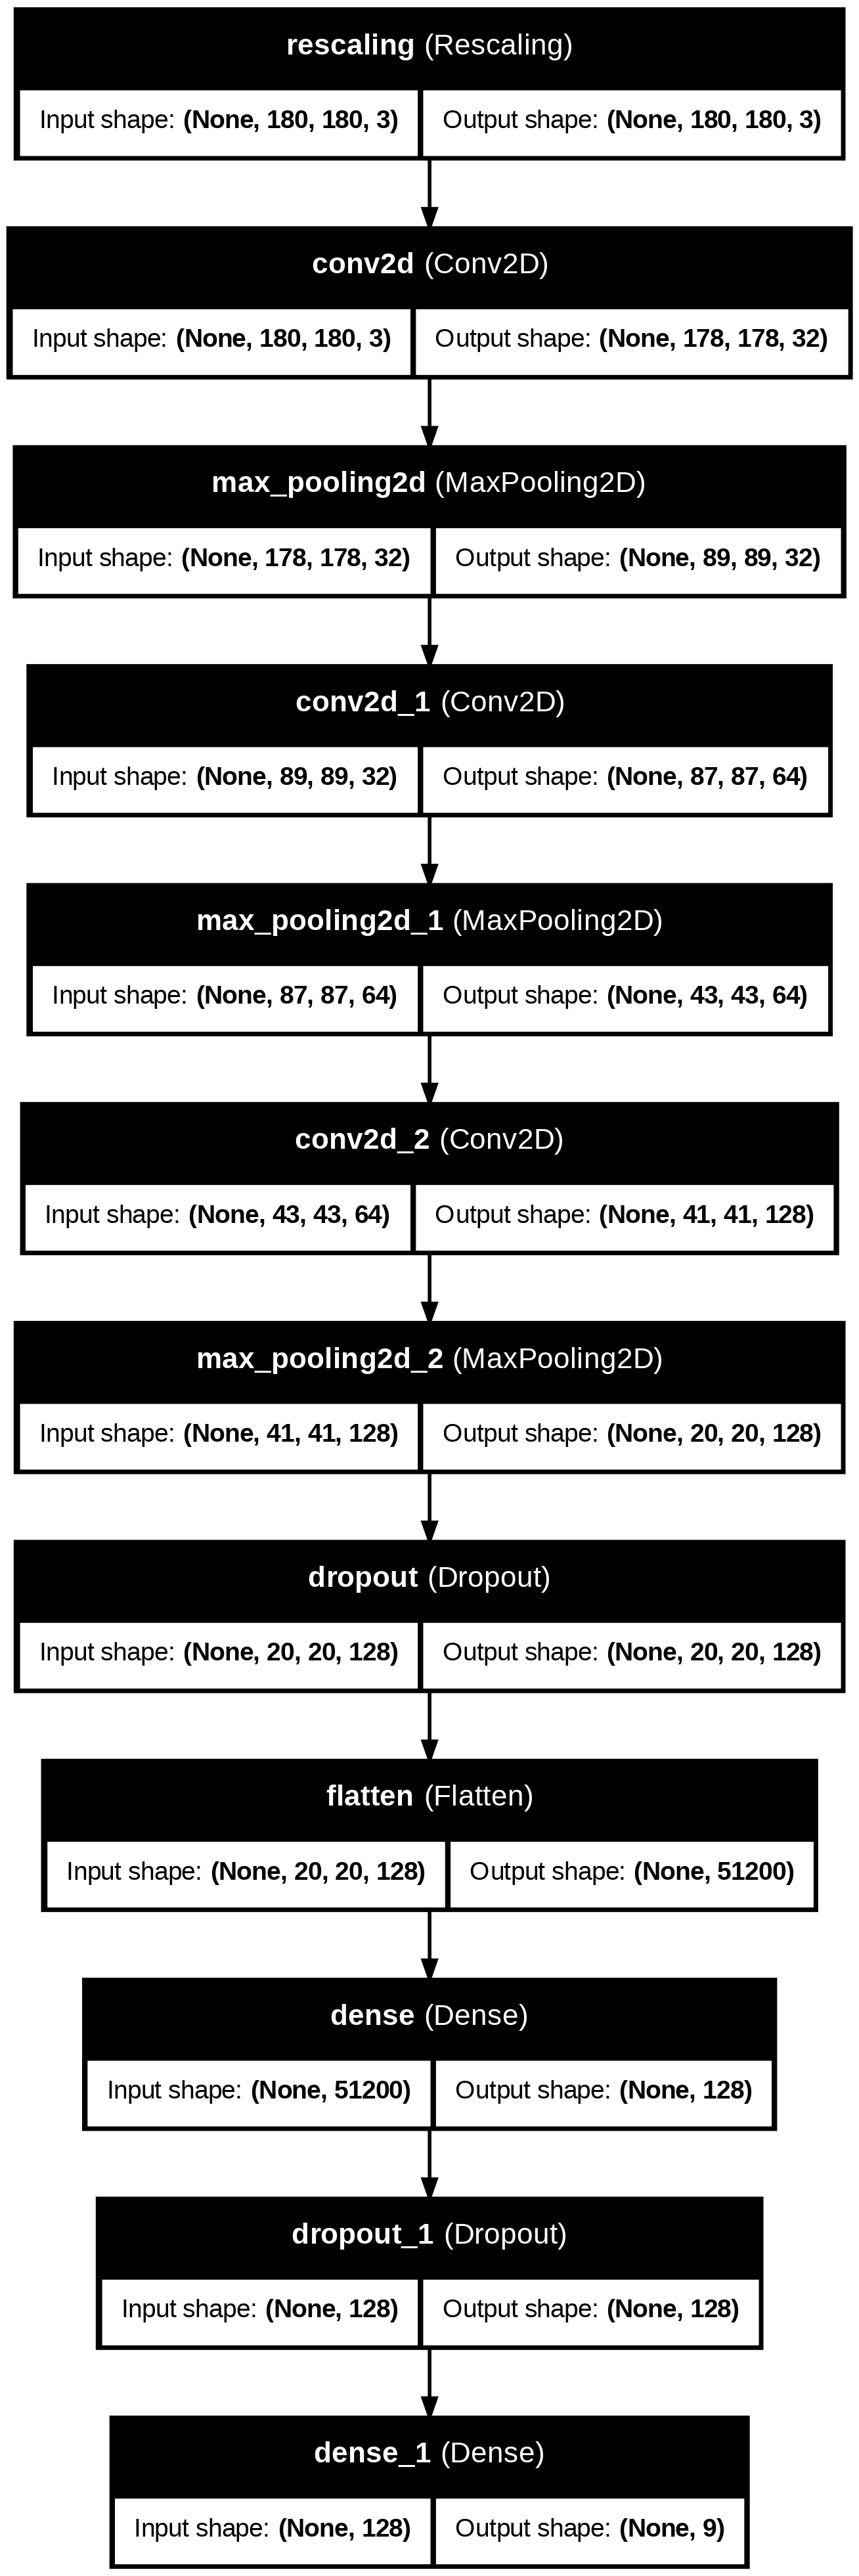

In [39]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
# categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# ModelCheckpoint callback: saves the best model based on validation accuracy
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# EarlyStopping callback: stops training if the validation accuracy stops improving
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)


In [42]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1953 - loss: 2.1182
Epoch 1: val_accuracy improved from -inf to 0.41574, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.1961 - loss: 2.1159 - val_accuracy: 0.4157 - val_loss: 1.5626
Epoch 2/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3821 - loss: 1.6426
Epoch 2: val_accuracy improved from 0.41574 to 0.44692, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - accuracy: 0.3823 - loss: 1.6419 - val_accuracy: 0.4469 - val_loss: 1.4022
Epoch 3/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4539 - loss: 1.4211
Epoch 3: val_accuracy improved from 0.44692 to 0.49666, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4540 - loss: 1.4209 - val_accuracy: 0.4967 - val_loss: 1.3576
Epoch 4/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5269 - loss: 1.2831
Epoch 4: val_accuracy improved from 0.49666 to 

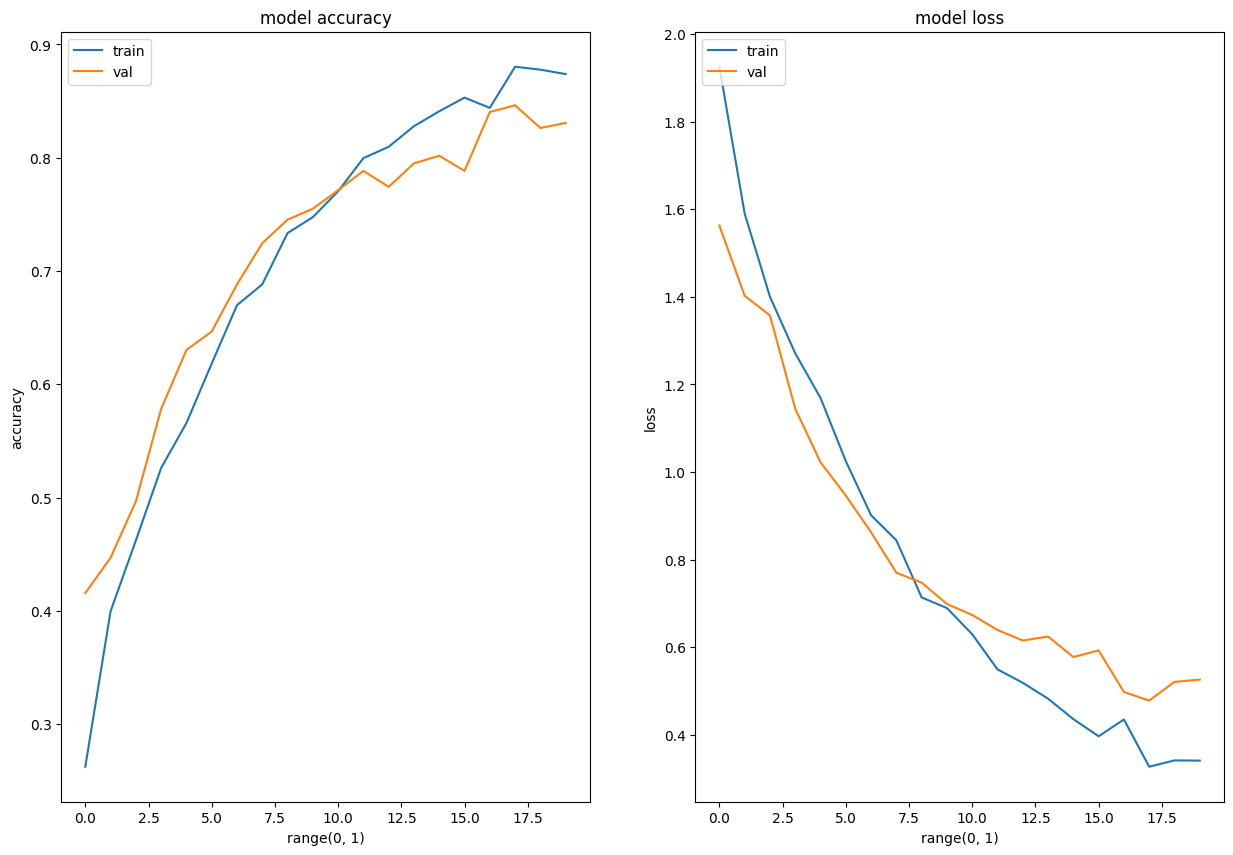

In [43]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class basal cell carcinoma
Predictive Class melanoma


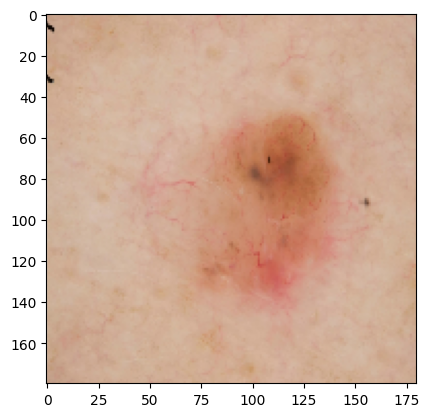

In [49]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


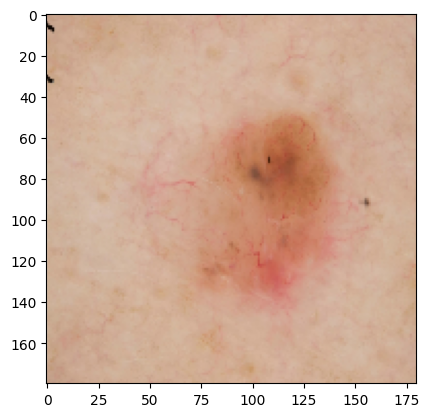

Actual Class: basal cell carcinoma
Predicted Class: pigmented benign keratosis


In [47]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load the last image from the glob result
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image_files = glob(Test_image_path)

# Check if images are found
if Test_image_files:
    # Load the test image and resize to (180, 180)
    Test_image = load_img(Test_image_files[-1], target_size=(180, 180))

    # Convert the image to a numpy array and rescale it (since the model was trained with rescaling)
    Test_image_array = img_to_array(Test_image)
    Test_image_array = Test_image_array / 255.0  # Apply rescaling

    # Expand the dimensions of the image to make it a batch of size 1
    img = np.expand_dims(Test_image_array, axis=0)

    # Make the prediction
    pred = model.predict(img)

    # Get the predicted class index and the class label
    pred = np.argmax(pred)
    pred_class = class_names[pred]

    # Plot the image and print the results
    plt.imshow(Test_image)
    plt.grid(False)
    plt.show()

    print(f"Actual Class: {class_names[1]}")
    print(f"Predicted Class: {pred_class}")
else:
    print("No test images found.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Top 3 Predictions:
melanoma: 0.7378
basal cell carcinoma: 0.2431
seborrheic keratosis: 0.0180

Predicted Class: melanoma


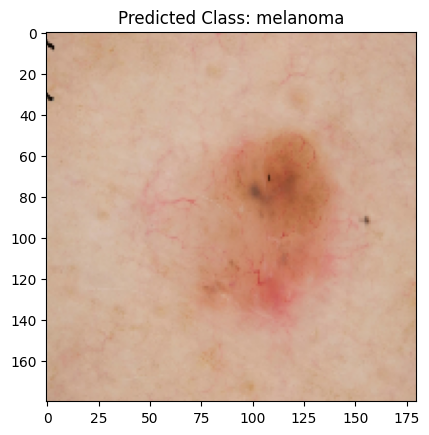

In [50]:
# Check the predicted probabilities for each class
pred_prob = model.predict(img)

# Get the class probabilities and the corresponding class labels
pred_probabilities = pred_prob[0]  # Since it's a batch of size 1
class_probabilities = list(zip(class_names, pred_probabilities))

# Sort the classes by probability in descending order
sorted_classes = sorted(class_probabilities, key=lambda x: x[1], reverse=True)

# Print the top 3 predictions
print("Top 3 Predictions:")
for class_name, prob in sorted_classes[:3]:
    print(f"{class_name}: {prob:.4f}")

# Also, print the predicted class
pred_class = class_names[np.argmax(pred_probabilities)]
print(f"\nPredicted Class: {pred_class}")

# Visualize the image
plt.imshow(Test_image)
plt.title(f"Predicted Class: {pred_class}")
plt.grid(False)
plt.show()
